# Overfitting demo

## Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [1]:
import graphlab
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to miguelfzafra@gmail.com and will expire on July 28, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1534096378.log


Create random values for x in interval [0,1)

In [2]:
random.seed(98103)
n = 30
x = graphlab.SArray([random.random() for i in range(n)]).sort()

Compute y

In [3]:
y = x.apply(lambda x: math.sin(4*x))

Add random Gaussian noise to y

In [4]:
random.seed(1)
e = graphlab.SArray([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into an SFrame to manipulate later

In [6]:
data = graphlab.SFrame({'X1':x,'Y':y})
data.head(3)

X1,Y
0.0395789449501,0.587050191026
0.0415680996791,0.648655851372
0.0724319480801,0.307803309485


### Create a function to plot the data, since we'll do it many times

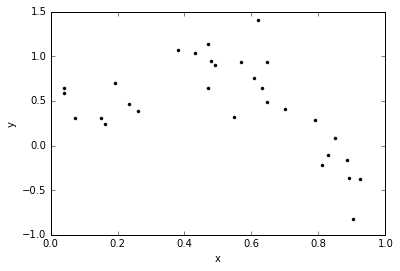

In [7]:
def plot_data(data):    
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [8]:
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [9]:
def polynomial_regression(data, deg):
    model = graphlab.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=0.,l1_penalty=0.,
                                              validation_set=None,verbose=False)
    return model

Todo lo que veremos de Ridge y Lasso estará en esos parámetros:
* `l1_penalty`
* `l2_penalty`

Lo veremos, pero hay que saber que si los dos están a cero tenemos una regresión normal por OLS.

Define function to plot data and predictions made, since we are going to use it many times.

In [10]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = graphlab.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way :)

In [14]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1

    # Get learned parameters as a list
    w = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print 'Learned polynomial for degree ' + str(deg) + ':'
    print ''
    w.reverse()
    print numpy.poly1d(w)

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [12]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [15]:
print_coefficients(model)

Learned polynomial for degree 2:

        2
-5.129 x + 4.147 x + 0.07471


Form and plot our predictions along a grid of x values:

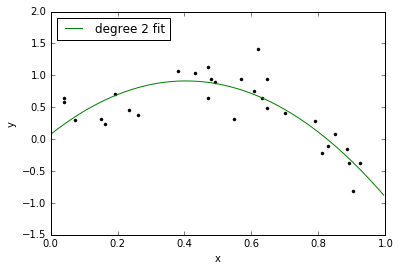

In [16]:
plot_poly_predictions(data,model)

Tiene buena pinta. Vemos que los coeficientes son razonablemente pequeños (-5, 4, 0, etc...)

## Fit a degree-4 polynomial

Learned polynomial for degree 4:

       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


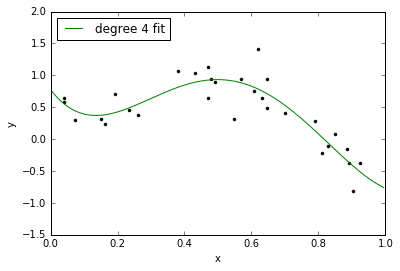

In [17]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)

Vemos que los coeficientes han aumentado bastante. El fit ahora tampoco tiene mala pinta.

## Fit a degree-16 polynomial

In [18]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:

           16             15             14             13
5.327e+05 x  - 4.611e+06 x  + 1.411e+07 x  - 1.982e+07 x 
              12             11             10             9
 + 1.092e+07 x  + 3.755e+06 x  - 8.639e+06 x  + 5.854e+06 x
              8             7             6           5             4
 - 4.552e+06 x + 4.713e+06 x - 3.422e+06 x + 1.5e+06 x - 3.954e+05 x
              3        2
 + 6.139e+04 x - 5241 x + 211.4 x - 2.51


### Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

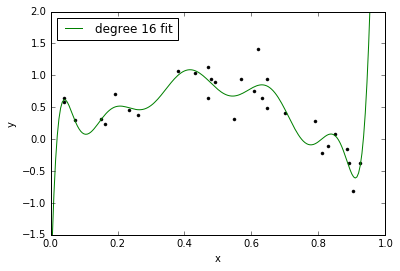

In [20]:
plot_poly_predictions(data,model)

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

Vemos que efectivamente, en modelos overfit, los coeficientes son enormes.

                                     ---

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is **penalizing fits with large coefficients**.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [21]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = graphlab.linear_regression.create(polynomial_features(data,deg), 
                                              target='Y', l2_penalty=l2_penalty,
                                              validation_set=None,verbose=False)
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [22]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

Learned polynomial for degree 16:

           16             15             14             13
5.327e+05 x  - 4.611e+06 x  + 1.411e+07 x  - 1.982e+07 x 
              12             11             10             9
 + 1.092e+07 x  + 3.755e+06 x  - 8.639e+06 x  + 5.854e+06 x
              8             7             6           5             4
 - 4.552e+06 x + 4.713e+06 x - 3.422e+06 x + 1.5e+06 x - 3.954e+05 x
              3        2
 + 6.139e+04 x - 5241 x + 211.4 x - 2.51


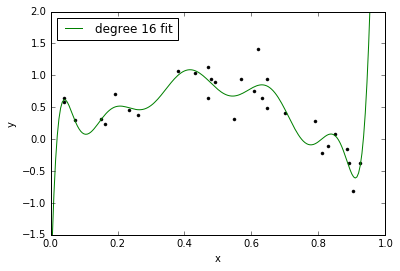

In [23]:
plot_poly_predictions(data,model)

Es prácticamente igual que en el caso en el que no metíamos término de regularización. Los coeficientes siguen siendo muy altos.

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [27]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:

        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


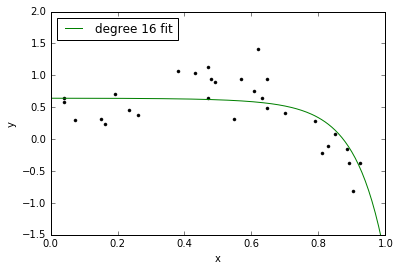

In [28]:
plot_poly_predictions(data,model)

Vemos que los coeficientes ahora son mucho más pequeños. El fit es ahora muy smooth, quizás demasiado simple (no parece que capture la tendencia del seno). Esto está underfit (nos vamos aproximando a `w = 0`).

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
Learned polynomial for degree 16:

           16             15             14             13
5.327e+05 x  - 4.611e+06 x  + 1.411e+07 x  - 1.982e+07 x 
              12             11             10             9
 + 1.092e+07 x  + 3.755e+06 x  - 8.639e+06 x  + 5.854e+06 x
              8             7             6           5             4
 - 4.552e+06 x + 4.713e+06 x - 3.422e+06 x + 1.5e+06 x - 3.954e+05 x
              3        2
 + 6.139e+04 x - 5241 x + 211.4 x - 2.51


lambda = 1.00e-10
Learned polynomial for degree 16:

           16            15             14             13
4.974e+04 x  - 7.82e+04 x  - 2.266e+04 x  + 3.949e+04 x 
              12        11             10             9             8
 + 4.365e+04 x  + 3079 x  - 3.332e+04 x  - 2.786e+04 x + 1.033e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1439 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.2 x - 65.19 x + 2.159


lambda = 1.00e-06
Learned polyno

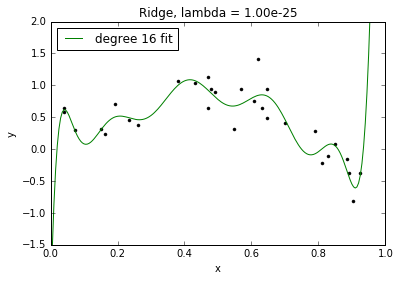

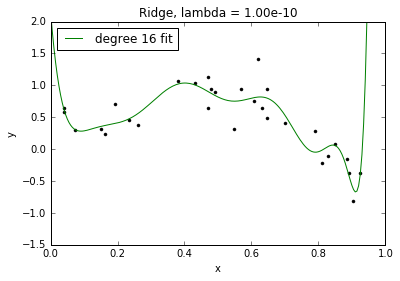

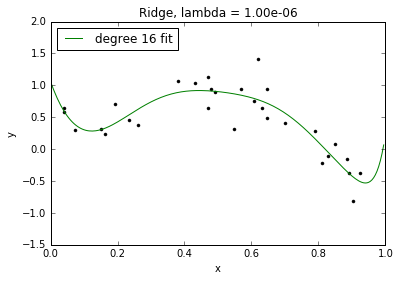

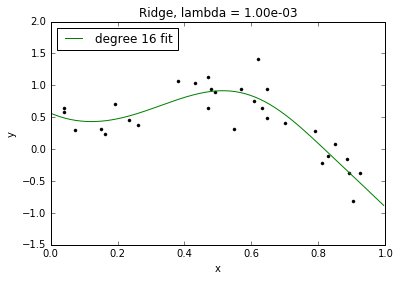

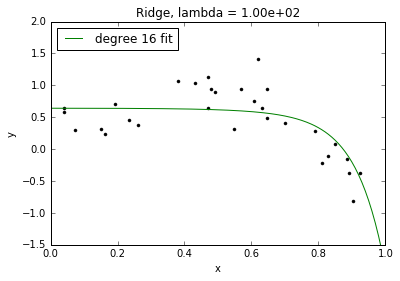

In [26]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

Vamos subiendo lambda y la función se va haciendo menos overfit.

Y qué lambda cogemos? Existe una manera automática de obtener el mejor lambda -> **Leave One Out Cross-Validation (LOOCV)**.

Lo que hace este método de Cross-Validation es que se aproxima el LOO error al MSE, por lo que minimizar uno me minimiza el otro.

Veremos más sobre Cross-Validation después.

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

In [31]:
# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    data = polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
    folds = graphlab.cross_validation.KFold(data,num_folds)
    
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            # train model
            model = graphlab.linear_regression.create(train_set,target='Y', 
                                                      l2_penalty=l2_penalty,
                                                      validation_set=None,verbose=False)
            
            # predict on validation set 
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
        
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse,best_l2_penalty

Los detalles los veremos más adelante, porque aquí no se usa train-validation-test sets.

Run LOO cross validation for "num" values of lambda, on a log scale

In [32]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse,best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

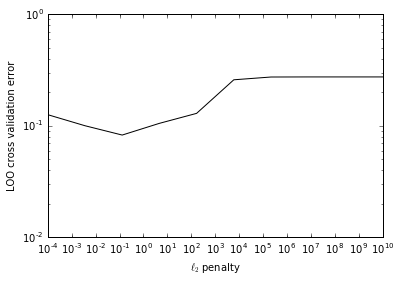

In [33]:
plt.plot(l2_penalty_values,l2_penalty_mse,'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Esto representa el `LOOCV error` frente al $\lambda$ en escala logarítmica. Vemos que es más o menos plano.

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [35]:
# Obtenemos el lambda que tiene el menor LOOCV error

best_l2_penalty

0.12915496650148839

In [37]:
# Fitteamos el modelo con ese lambda

model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree 16:

       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


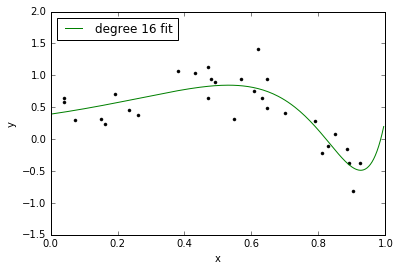

In [38]:
plot_poly_predictions(data,model)

Más o menos está bien, salvo en el último tramo pero no tenemos datos, por lo que va a ser complicado obtener algo mejor que eso.

Pero esto está bien, hay que tener en cuenta que es un polinomio de **grado 16**!!!